In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6de0cd1829085cc11e57a64e14ea9319722176af66ce7fee116952f1b165a420
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Arima**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



Root Mean Squared Error: 33.552693948664526
R^2: -0.14302980711084134


<ipython-input-8-2dc73017d159>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



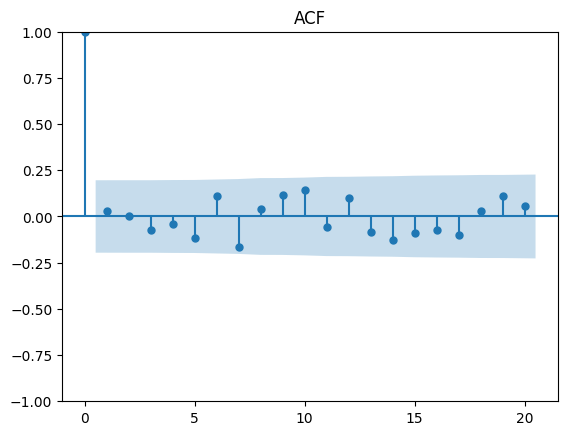

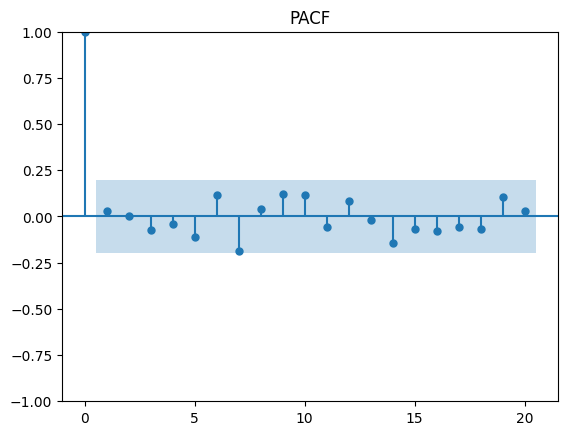

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2018', periods=100, freq='M'),
    'value': np.random.rand(100) * 100
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True)

# Dividir el dataset en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Crear y entrenar el modelo ARIMA
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Hacer predicciones
predictions = model_fit.forecast(steps=len(test))
test['predictions'] = predictions

# Eliminar filas con NaN
test = test.dropna()

if not test.empty:
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
    r2 = r2_score(test['value'], test['predictions'])
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2: {r2}')

    # Gráfico de Predicciones vs. Valores Reales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test.index, y=test['value'], mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=test.index, y=test['predictions'], mode='lines', name='Predicciones'))
    fig.update_layout(title='Predicciones vs. Valores Reales',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      showlegend=True)
    fig.show()

# Gráfico de ACF y PACF
plot_acf(df['value'].dropna())
plt.title('ACF')
plt.show()

plot_pacf(df['value'].dropna())
plt.title('PACF')
plt.show()

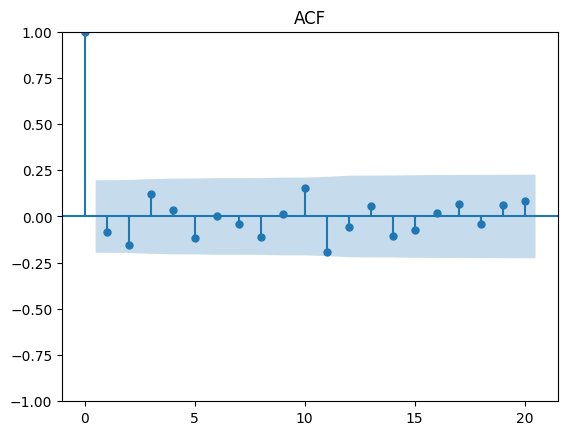

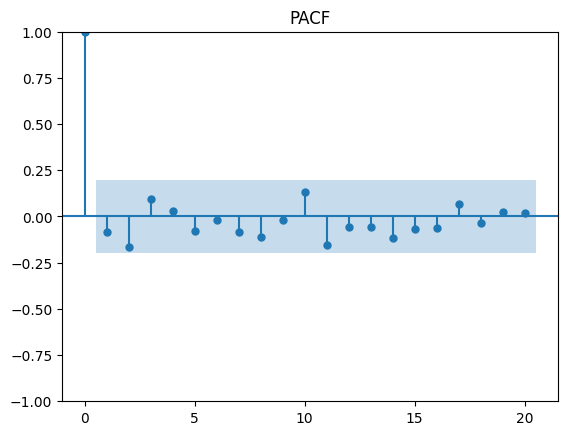

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear la sesión de Spark
spark = SparkSession.builder.appName('ARIMA').getOrCreate()

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2018', periods=100, freq='M'),
    'value': np.random.rand(100) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['value'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_spark.count() * 0.8)
train = df_spark.limit(train_size)
test = df_spark.subtract(train)

# Convertir el dataset de nuevo a pandas para usar ARIMA
train_pd = train.toPandas()
test_pd = test.toPandas()

# Crear y entrenar el modelo ARIMA
model = ARIMA(train_pd['value'], order=(5, 1, 0))
model_fit = model.fit()

# Hacer predicciones
predictions = model_fit.forecast(steps=len(test_pd))
test_pd['predictions'] = predictions

# Eliminar filas con NaN
test_pd = test_pd.dropna()

if not test_pd.empty:
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test_pd['value'], test_pd['predictions']))
    r2 = r2_score(test_pd['value'], test_pd['predictions'])
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2: {r2}')

    # Gráfico de Predicciones vs. Valores Reales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['value'], mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['predictions'], mode='lines', name='Predicciones'))
    fig.update_layout(title='Predicciones vs. Valores Reales',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      showlegend=True)
    fig.show()

# Gráfico de ACF y PACF
plot_acf(df['value'].dropna())
plt.title('ACF')
plt.show()

plot_pacf(df['value'].dropna())
plt.title('PACF')
plt.show()

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2018', periods=100, freq='M'),
    'value': np.random.rand(100) * 100
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True)

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Crear y entrenar el modelo ARIMA
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    test['predictions'] = predictions

    # Eliminar filas con NaN
    test = test.dropna()

    if not test.empty:
        # Evaluar el modelo
        rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
        r2 = r2_score(test['value'], test['predictions'])
        rmse_scores.append(rmse)
        r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

<ipython-input-10-06fb5accddf0>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M w

RMSE Scores: [31.833039687716703, 28.009345315615573, 35.51706825215797, 25.262134567751442, 23.73137286417105]
Average RMSE: 28.87059213748255
R^2 Scores: [-0.3590662876657542, -0.6311196119813318, -0.4650530943915887, -0.11979674356594927, -0.19033466224658824]
Average R^2: -0.3530740799702424


<ipython-input-10-06fb5accddf0>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Crear la sesión de Spark
spark = SparkSession.builder.appName('ARIMA').getOrCreate()

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2018', periods=100, freq='M'),
    'value': np.random.rand(100) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['value'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Convertir el dataset de nuevo a pandas para usar ARIMA
data_pd = df_spark.toPandas()

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(data_pd):
    train, test = data_pd.iloc[train_index], data_pd.iloc[test_index]

    # Crear y entrenar el modelo ARIMA
    model = ARIMA(train['value'], order=(5, 1, 0))
    model_fit = model.fit()

    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    test['predictions'] = predictions

    # Eliminar filas con NaN
    test = test.dropna()

    if not test.empty:
        # Evaluar el modelo
        rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
        r2 = r2_score(test['value'], test['predictions'])
        rmse_scores.append(rmse)
        r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

<ipython-input-11-ac22c6aedf8b>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-ac22c6aedf8b>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-ac22c6aedf8b>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-11-ac22

RMSE Scores: [32.95379392728156, 28.93548232486273, 29.596895119538257, 29.239154467576153, 33.466782840559034]
Average RMSE: 30.83842173596355
R^2 Scores: [-0.2408513156492571, -0.1055784760711076, -0.1810012013253932, -0.08015654955063534, -0.24423077831977524]
Average R^2: -0.1703636641832337


<ipython-input-11-ac22c6aedf8b>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Sarima**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



Root Mean Squared Error: 34.14153236235309
R^2: -0.12887543523069622


<ipython-input-12-980b0950eff6>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



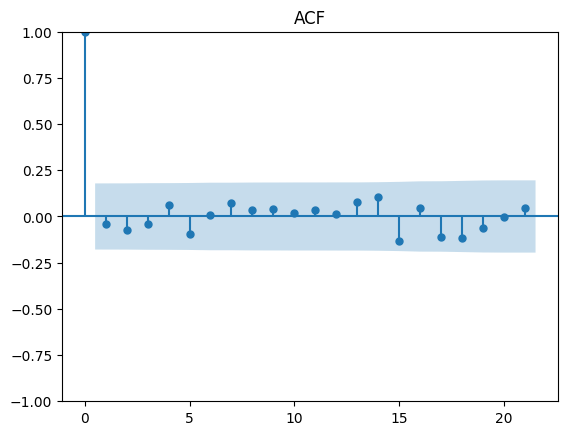

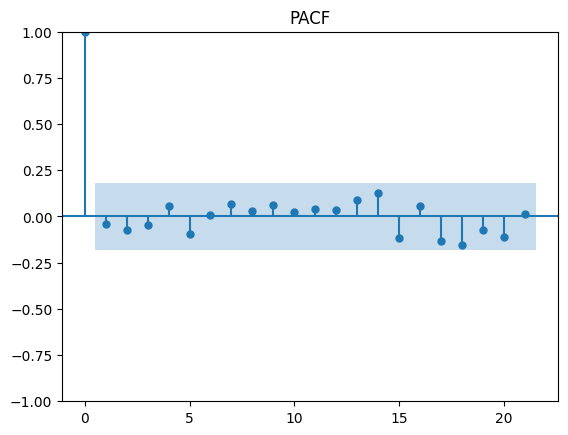

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True)

# Dividir el dataset en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Crear y entrenar el modelo SARIMA
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Hacer predicciones
predictions = model_fit.forecast(steps=len(test))
test['predictions'] = predictions

# Eliminar filas con NaN
test = test.dropna()

if not test.empty:
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
    r2 = r2_score(test['value'], test['predictions'])
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2: {r2}')

    # Gráfico de Predicciones vs. Valores Reales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test.index, y=test['value'], mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=test.index, y=test['predictions'], mode='lines', name='Predicciones'))
    fig.update_layout(title='Predicciones vs. Valores Reales',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      showlegend=True)
    fig.show()

# Gráfico de ACF y PACF
plot_acf(df['value'].dropna())
plt.title('ACF')
plt.show()

plot_pacf(df['value'].dropna())
plt.title('PACF')
plt.show()

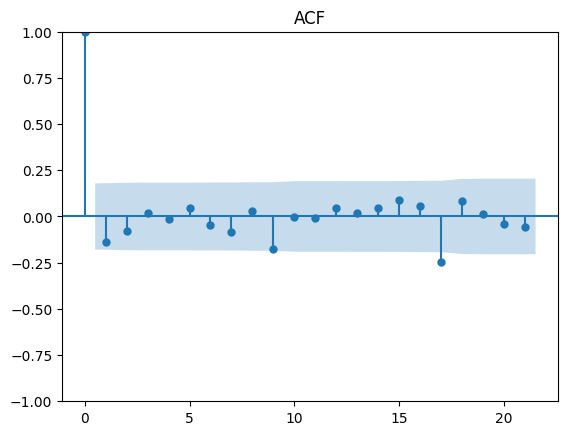

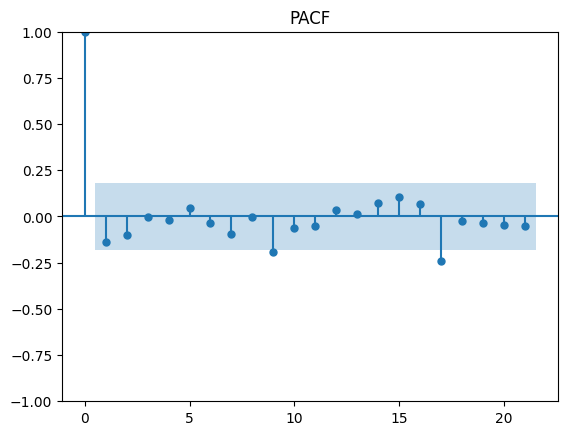

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear la sesión de Spark
spark = SparkSession.builder.appName('SARIMA').getOrCreate()

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['value'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_spark.count() * 0.8)
train = df_spark.limit(train_size)
test = df_spark.subtract(train)

# Convertir el dataset de nuevo a pandas para usar SARIMA
train_pd = train.toPandas()
test_pd = test.toPandas()

# Crear y entrenar el modelo SARIMA
model = SARIMAX(train_pd['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Hacer predicciones
predictions = model_fit.forecast(steps=len(test_pd))
test_pd['predictions'] = predictions

# Eliminar filas con NaN
test_pd = test_pd.dropna()

if not test_pd.empty:
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test_pd['value'], test_pd['predictions']))
    r2 = r2_score(test_pd['value'], test_pd['predictions'])
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2: {r2}')

    # Gráfico de Predicciones vs. Valores Reales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['value'], mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['predictions'], mode='lines', name='Predicciones'))
    fig.update_layout(title='Predicciones vs. Valores Reales',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      showlegend=True)
    fig.show()

# Gráfico de ACF y PACF
plot_acf(df['value'].dropna())
plt.title('ACF')
plt.show()

plot_pacf(df['value'].dropna())
plt.title('PACF')
plt.show()

In [14]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True)

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Crear y entrenar el modelo SARIMA
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    test['predictions'] = predictions

    # Eliminar filas con NaN
    test = test.dropna()

    if not test.empty:
        # Evaluar el modelo
        rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
        r2 = r2_score(test['value'], test['predictions'])
        rmse_scores.append(rmse)
        r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

<ipython-input-14-99c4a6e67ae2>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

RMSE Scores: [37.49068181091656, 29.2560762856384, 41.87236321368328, 39.49473273790868, 29.102348893302576]
Average RMSE: 35.4432405882899
R^2 Scores: [-1.2456711476273066, 0.060023153337391943, -0.7757025036365814, -0.9844380091507647, -0.131592741708092]
Average R^2: -0.6154762497570706


<ipython-input-14-99c4a6e67ae2>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Crear la sesión de Spark
spark = SparkSession.builder.appName('SARIMA').getOrCreate()

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['value'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Convertir el dataset de nuevo a pandas para usar SARIMA
data_pd = df_spark.toPandas()

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(data_pd):
    train, test = data_pd.iloc[train_index], data_pd.iloc[test_index]

    # Crear y entrenar el modelo SARIMA
    model = SARIMAX(train['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    test['predictions'] = predictions

    # Eliminar filas con NaN
    test = test.dropna()

    if not test.empty:
        # Evaluar el modelo
        rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
        r2 = r2_score(test['value'], test['predictions'])
        rmse_scores.append(rmse)
        r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

<ipython-input-15-000f64a0d3e6>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

<ipython-input-15-000f64a0d3e6>:49: SettingWithCopyWarn

RMSE Scores: [42.03784164392721, 44.97876788402538, 33.8533293483097, 36.42280825668292, 33.087396169154324]
Average RMSE: 38.07602866041991
R^2 Scores: [-0.9221092533472777, -1.0517573328037684, -0.5359178822554314, -0.4223814513374242, -0.2655922633411858]
Average R^2: -0.6395516366170175


<ipython-input-15-000f64a0d3e6>:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Holt-Winters (Triple Exponential Smoothing)**

Root Mean Squared Error: 32.975546502353986
R^2: -0.32427958632961085


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

<ipython-input-18-d35e1f21e27a>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



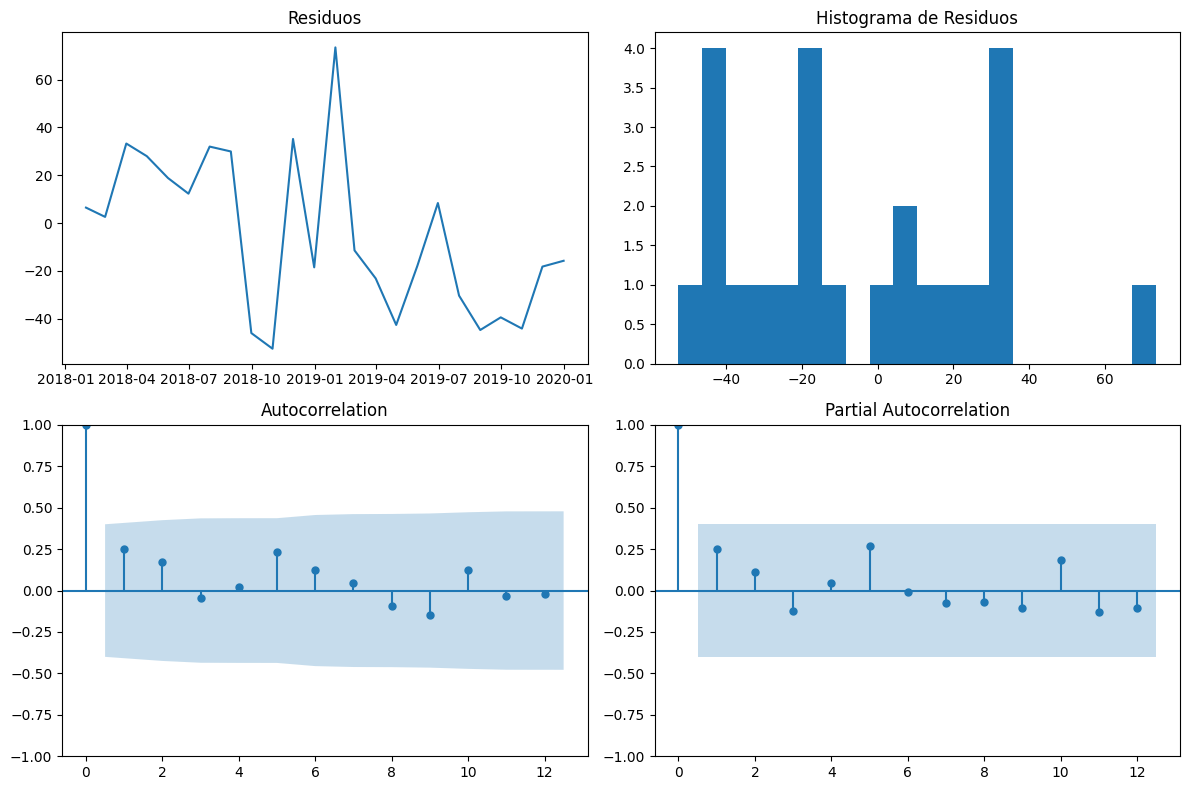

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True)

# Dividir el dataset en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Crear y entrenar el modelo Holt-Winters
model = ExponentialSmoothing(train['value'], seasonal='add', seasonal_periods=12).fit()
predictions = model.forecast(steps=len(test))
test['predictions'] = predictions

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test['value'], test['predictions']))
r2 = r2_score(test['value'], test['predictions'])
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2: {r2}')

# Gráfico de Predicciones vs. Valores Reales
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['value'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=test.index, y=test['predictions'], mode='lines', name='Predicciones'))
fig.update_layout(title='Predicciones vs. Valores Reales',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  showlegend=True)
fig.show()

# Gráficos de diagnóstico manuales
residuals = test['value'] - test['predictions']
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Gráfico de residuos
ax[0, 0].plot(residuals)
ax[0, 0].set_title('Residuos')

# Histograma de residuos
ax[0, 1].hist(residuals, bins=20)
ax[0, 1].set_title('Histograma de Residuos')

# ACF de residuos
plot_acf(residuals, ax=ax[1, 0])

# PACF de residuos
plot_pacf(residuals, ax=ax[1, 1])

plt.tight_layout()
plt.show()

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Crear la sesión de Spark
spark = SparkSession.builder.appName('HoltWinters').getOrCreate()

# Crear dataset de ejemplo
data = {
    'date': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'value': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# VectorAssembler para características
assembler = VectorAssembler(inputCols=['value'], outputCol='features')
df_spark = assembler.transform(df_spark)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_spark.count() * 0.8)
train = df_spark.limit(train_size)
test = df_spark.subtract(train)

# Convertir el dataset de nuevo a pandas para usar Holt-Winters
train_pd = train.toPandas()
test_pd = test.toPandas()

# Crear y entrenar el modelo Holt-Winters
model = ExponentialSmoothing(train_pd['value'], seasonal='add', seasonal_periods=12).fit()
predictions = model.forecast(steps=len(test_pd))
test_pd['predictions'] = predictions

# Eliminar filas con NaN
test_pd = test_pd.dropna()

if not test_pd.empty:
    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test_pd['value'], test_pd['predictions']))
    r2 = r2_score(test_pd['value'], test_pd['predictions'])
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2: {r2}')

    # Gráfico de Predicciones vs. Valores Reales
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['value'], mode='lines', name='Real'))
    fig.add_trace(go.Scatter(x=test_pd['date'], y=test_pd['predictions'], mode='lines', name='Predicciones'))
    fig.update_layout(title='Predicciones vs. Valores Reales',
                      xaxis_title='Fecha',
                      yaxis_title='Valor',
                      showlegend=True)
    fig.show()

    # Gráficos de diagnóstico manuales
    residuals = test_pd['value'] - test_pd['predictions']
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Gráfico de residuos
    ax[0, 0].plot(residuals)
    ax[0, 0].set_title('Residuos')

    # Histograma de residuos
    ax[0, 1].hist(residuals, bins=20)
    ax[0, 1].set_title('Histograma de Residuos')

    # ACF de residuos
    plot_acf(residuals, ax=ax[1, 0])

    # PACF de residuos
    plot_pacf(residuals, ax=ax[1, 1])

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes datos después de eliminar NaN para calcular RMSE y R^2.")

No hay suficientes datos después de eliminar NaN para calcular RMSE y R^2.


# **Prophet**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/l4dcrpwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/84_1l3ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85450', 'data', 'file=/tmp/tmpmkzux8jr/l4dcrpwi.json', 'init=/tmp/tmpmkzux8jr/84_1l3ih.json', 'output', 'file=/tmp/tmpmkzux8jr/prophet_model19z9plwj/prophet_model-20240717075359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:53:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error: 34.544872745949064
Mean Absolute Error: 28.847624926273667
R^2: -0.5315549626419598


<ipython-input-27-eee45cd22625>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



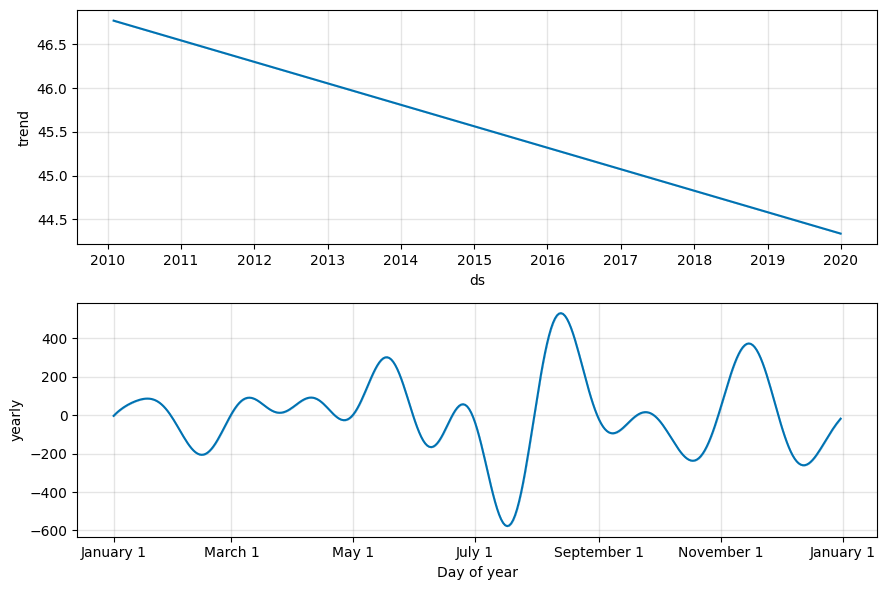

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.graph_objects as go

# Crear dataset de ejemplo
data = {
    'ds': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'y': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Dividir el dataset en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(train)

# Hacer predicciones
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)
test['yhat'] = forecast['yhat'].iloc[-len(test):].values

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test['y'], test['yhat']))
mae = mean_absolute_error(test['y'], test['yhat'])
r2 = r2_score(test['y'], test['yhat'])
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')

# Gráfico de Predicciones vs. Valores Reales
fig = go.Figure()
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=test['ds'], y=test['yhat'], mode='lines', name='Predicciones'))
fig.update_layout(title='Predicciones vs. Valores Reales',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  showlegend=True)
fig.show()

# Componentes del modelo
fig2 = model.plot_components(forecast)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/ts_ile8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/u6_03xmo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18737', 'data', 'file=/tmp/tmpmkzux8jr/ts_ile8l.json', 'init=/tmp/tmpmkzux8jr/u6_03xmo.json', 'output', 'file=/tmp/tmpmkzux8jr/prophet_modelqlamy3j2/prophet_model-20240717075417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:54:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:54:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Root Mean Squared Error: 32.989206708548046
Mean Absolute Error: 29.49987635102002
R^2: -0.2116546227577254


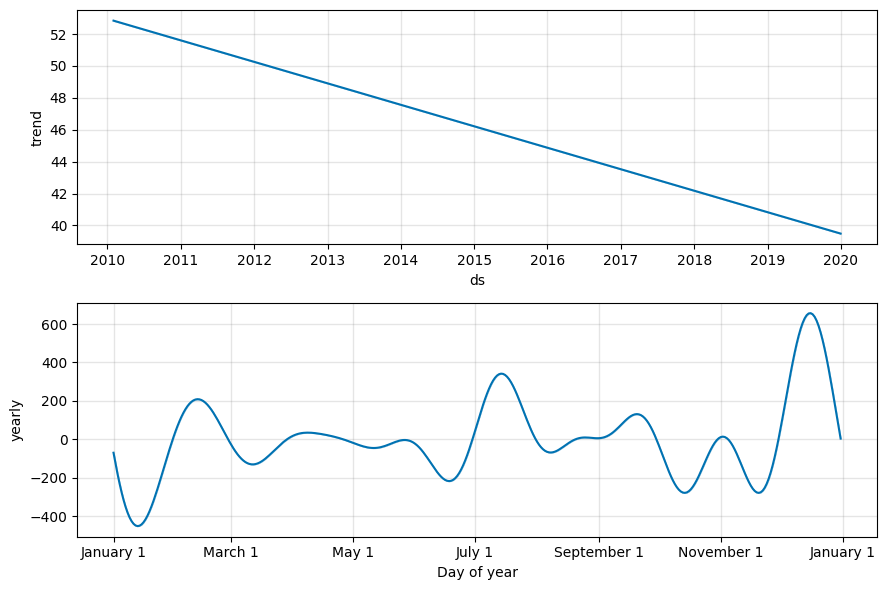

In [28]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('Prophet').getOrCreate()

# Crear dataset de ejemplo
data = {
    'ds': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'y': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_spark.count() * 0.8)
train = df_spark.limit(train_size)
test = df_spark.subtract(train)

# Convertir el dataset de nuevo a pandas para usar Prophet
train_pd = train.toPandas()
test_pd = test.toPandas()

# Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(train_pd)

# Hacer predicciones
future = model.make_future_dataframe(periods=len(test_pd), freq='M')
forecast = model.predict(future)
test_pd['yhat'] = forecast['yhat'].iloc[-len(test_pd):].values

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test_pd['y'], test_pd['yhat']))
mae = mean_absolute_error(test_pd['y'], test_pd['yhat'])
r2 = r2_score(test_pd['y'], test_pd['yhat'])
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2}')

# Gráfico de Predicciones vs. Valores Reales
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_pd['ds'], y=test_pd['y'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=test_pd['ds'], y=test_pd['yhat'], mode='lines', name='Predicciones'))
fig.update_layout(title='Predicciones vs. Valores Reales',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  showlegend=True)
fig.show()

# Componentes del modelo
fig2 = model.plot_components(forecast)
plt.show()

In [29]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear dataset de ejemplo
data = {
    'ds': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'y': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Crear y entrenar el modelo Prophet
    model = Prophet()
    model.fit(train)

    # Hacer predicciones
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    test['yhat'] = forecast['yhat'].iloc[-len(test):].values

    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test['y'], test['yhat']))
    mae = mean_absolute_error(test['y'], test['yhat'])
    r2 = r2_score(test['y'], test['yhat'])
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'MAE Scores: {mae_scores}')
print(f'Average MAE: {np.mean(mae_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=mae_scores, mode='lines+markers', name='MAE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/79miajzx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/mpqo5r10.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35976', 'data', 'file=/tmp/tmpmkzux8jr/79miajzx.json', 'init=/tmp/tmpmkzux8jr/mpqo5r10.json', 'output', 'file=/tmp/tmpmkzux8jr/prophet_model255lrlcq/prophet_model-20240717075439.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:54:39 - cmdstanpy - INFO - Chain [1] start processing
I

RMSE Scores: [30.400741413094256, 34.0915769688592, 45.63008949003839, 33.98637439428474, 35.93868030147942]
Average RMSE: 36.0094925135512
MAE Scores: [27.519768363118153, 27.46237180538767, 39.04826219825215, 29.049439320987098, 32.67364203294998]
Average MAE: 31.150696744139008
R^2 Scores: [-0.04847063081288194, -0.5714666884766728, -0.6681554173538216, -0.12974940617157316, -0.07131314064397754]
Average R^2: -0.2978310566917854


In [30]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('Prophet').getOrCreate()

# Crear dataset de ejemplo
data = {
    'ds': pd.date_range(start='1/1/2010', periods=120, freq='M'),
    'y': np.random.rand(120) * 100
}
df = pd.DataFrame(data)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df)

# Convertir el dataset de nuevo a pandas para usar Prophet
data_pd = df_spark.toPandas()

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in tscv.split(data_pd):
    train, test = data_pd.iloc[train_index], data_pd.iloc[test_index]

    # Crear y entrenar el modelo Prophet
    model = Prophet()
    model.fit(train)

    # Hacer predicciones
    future = model.make_future_dataframe(periods=len(test), freq='M')
    forecast = model.predict(future)
    test['yhat'] = forecast['yhat'].iloc[-len(test):].values

    # Evaluar el modelo
    rmse = np.sqrt(mean_squared_error(test['y'], test['yhat']))
    mae = mean_absolute_error(test['y'], test['yhat'])
    r2 = r2_score(test['y'], test['yhat'])
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Mostrar resultados
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'MAE Scores: {mae_scores}')
print(f'Average MAE: {np.mean(mae_scores)}')
print(f'R^2 Scores: {r2_scores}')
print(f'Average R^2: {np.mean(r2_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=mae_scores, mode='lines+markers', name='MAE'))
fig.add_trace(go.Scatter(y=r2_scores, mode='lines+markers', name='R^2'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/f8ohi4lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmkzux8jr/fgb6ucm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21208', 'data', 'file=/tmp/tmpmkzux8jr/f8ohi4lq.json', 'init=/tmp/tmpmkzux8jr/fgb6ucm2.json', 'output', 'file=/tmp/tmpmkzux8jr/prophet_model9s6rac9i/prophet_model-20240717075454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:54:54 - cmdstanpy - INFO - Chain [1] start processing
I

RMSE Scores: [31.21201902152745, 41.71130889932056, 36.4154901708513, 36.725946989059736, 30.774375043566955]
Average RMSE: 35.367828024865204
MAE Scores: [27.523351554993933, 36.00969451732117, 31.278786377147306, 29.310138723185094, 25.4729894215529]
Average MAE: 29.918992118840077
R^2 Scores: [-0.13339269136779208, -0.40799837751788104, -0.3513031245792404, -0.7129184755278115, -0.8749983430958903]
Average R^2: -0.49612220241772303


# **Arch**

In [32]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 10.9 MB/s eta 0:00:00


AIC: 2422.7951728030375
BIC: 2441.5336197137094
Log-Likelihood: -1207.3975864015188


<ipython-input-33-5c322ab71ca3>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



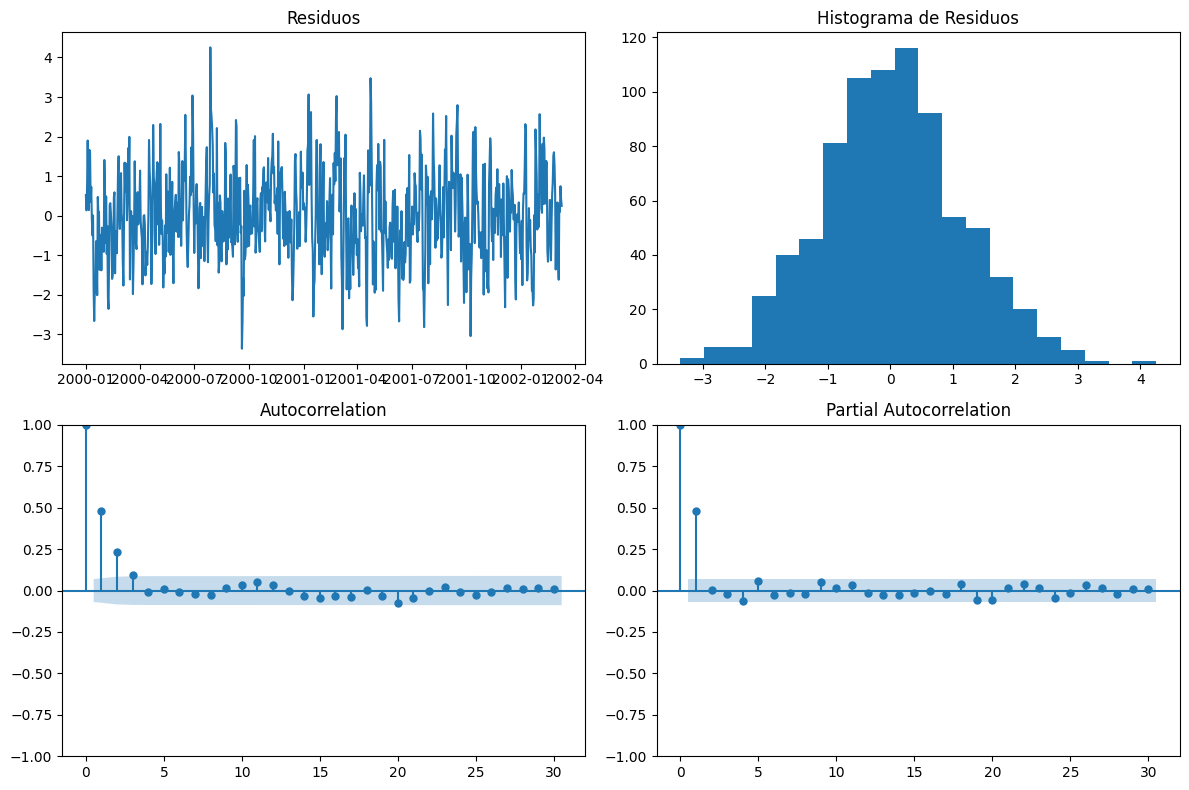

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

# Crear dataset de ejemplo
np.random.seed(42)
returns = np.random.normal(0, 1, 1000)
for t in range(1, len(returns)):
    returns[t] += 0.5 * returns[t-1]

df = pd.DataFrame({'date': pd.date_range(start='1/1/2000', periods=1000, freq='D'), 'returns': returns})
df.set_index('date', inplace=True)

# Dividir el dataset en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Crear y entrenar el modelo GARCH
model = arch_model(train['returns'], vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Hacer predicciones
forecast = model_fit.forecast(horizon=len(test))
test['forecast_variance'] = forecast.variance.values[-1, :]

# Evaluar el modelo
aic = model_fit.aic
bic = model_fit.bic
log_likelihood = model_fit.loglikelihood
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Log-Likelihood: {log_likelihood}')

# Gráfico de Predicciones de Volatilidad vs. Valores Reales
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['returns'], mode='lines', name='Retornos'))
fig.add_trace(go.Scatter(x=test.index, y=test['forecast_variance'], mode='lines', name='Varianza Predicha'))
fig.update_layout(title='Volatilidad Predicha vs. Retornos Reales',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  showlegend=True)
fig.show()

# Gráficos de diagnóstico manuales
residuals = model_fit.resid
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Gráfico de residuos
ax[0, 0].plot(residuals)
ax[0, 0].set_title('Residuos')

# Histograma de residuos
ax[0, 1].hist(residuals, bins=20)
ax[0, 1].set_title('Histograma de Residuos')

# ACF de residuos
plot_acf(residuals, ax=ax[1, 0])

# PACF de residuos
plot_pacf(residuals, ax=ax[1, 1])

plt.tight_layout()
plt.show()

AIC: 2422.7951728030375
BIC: 2441.5336197137094
Log-Likelihood: -1207.3975864015188


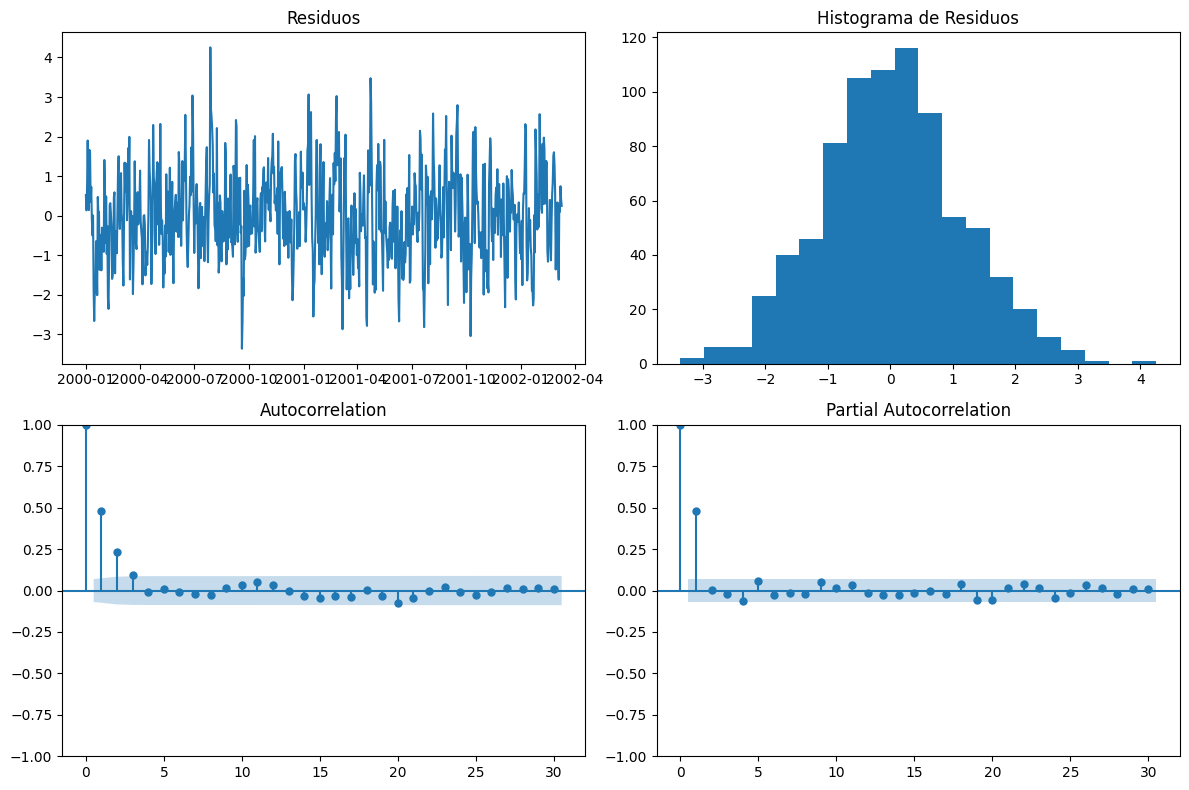

In [34]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('GARCH').getOrCreate()

# Crear dataset de ejemplo
np.random.seed(42)
returns = np.random.normal(0, 1, 1000)
for t in range(1, len(returns)):
    returns[t] += 0.5 * returns[t-1]

df = pd.DataFrame({'date': pd.date_range(start='1/1/2000', periods=1000, freq='D'), 'returns': returns})
df.set_index('date', inplace=True)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df.reset_index())

# Dividir el dataset en entrenamiento y prueba
train_size = int(df_spark.count() * 0.8)
train = df_spark.limit(train_size)
test = df_spark.subtract(train)

# Convertir el dataset de nuevo a pandas para usar GARCH
train_pd = train.toPandas().set_index('date')
test_pd = test.toPandas().set_index('date')

# Crear y entrenar el modelo GARCH
model = arch_model(train_pd['returns'], vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Hacer predicciones
forecast = model_fit.forecast(horizon=len(test_pd))
test_pd['forecast_variance'] = forecast.variance.values[-1, :]

# Evaluar el modelo
aic = model_fit.aic
bic = model_fit.bic
log_likelihood = model_fit.loglikelihood
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Log-Likelihood: {log_likelihood}')

# Gráfico de Predicciones de Volatilidad vs. Valores Reales
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_pd.index, y=test_pd['returns'], mode='lines', name='Retornos'))
fig.add_trace(go.Scatter(x=test_pd.index, y=test_pd['forecast_variance'], mode='lines', name='Varianza Predicha'))
fig.update_layout(title='Volatilidad Predicha vs. Retornos Reales',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  showlegend=True)
fig.show()

# Gráficos de diagnóstico manuales
residuals = model_fit.resid
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Gráfico de residuos
ax[0, 0].plot(residuals)
ax[0, 0].set_title('Residuos')

# Histograma de residuos
ax[0, 1].hist(residuals, bins=20)
ax[0, 1].set_title('Histograma de Residuos')

# ACF de residuos
plot_acf(residuals, ax=ax[1, 0])

# PACF de residuos
plot_pacf(residuals, ax=ax[1, 1])

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear dataset de ejemplo
np.random.seed(42)
returns = np.random.normal(0, 1, 1000)
for t in range(1, len(returns)):
    returns[t] += 0.5 * returns[t-1]

df = pd.DataFrame({'date': pd.date_range(start='1/1/2000', periods=1000, freq='D'), 'returns': returns})
df.set_index('date', inplace=True)

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
aic_scores = []
bic_scores = []
log_likelihood_scores = []

for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Crear y entrenar el modelo GARCH
    model = arch_model(train['returns'], vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')

    # Evaluar el modelo
    aic_scores.append(model_fit.aic)
    bic_scores.append(model_fit.bic)
    log_likelihood_scores.append(model_fit.loglikelihood)

# Mostrar resultados
print(f'AIC Scores: {aic_scores}')
print(f'Average AIC: {np.mean(aic_scores)}')
print(f'BIC Scores: {bic_scores}')
print(f'Average BIC: {np.mean(bic_scores)}')
print(f'Log-Likelihood Scores: {log_likelihood_scores}')
print(f'Average Log-Likelihood: {np.mean(log_likelihood_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=aic_scores, mode='lines+markers', name='AIC'))
fig.add_trace(go.Scatter(y=bic_scores, mode='lines+markers', name='BIC'))
fig.add_trace(go.Scatter(y=log_likelihood_scores, mode='lines+markers', name='Log-Likelihood'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

AIC Scores: [497.78748619038174, 989.333661989751, 1529.668256400871, 2031.1364996063912, 2525.355871872439]
Average AIC: 1514.656355211967
BIC Scores: [510.33067993858276, 1004.6021066296039, 1546.542656879638, 2049.153652300538, 2544.260805481874]
Average BIC: 1530.9779802460473
Log-Likelihood Scores: [-244.89374309519087, -490.6668309948755, -760.8341282004355, -1011.5682498031956, -1258.6779359362195]
Average Log-Likelihood: -753.3281776059835


In [36]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('GARCH').getOrCreate()

# Crear dataset de ejemplo
np.random.seed(42)
returns = np.random.normal(0, 1, 1000)
for t in range(1, len(returns)):
    returns[t] += 0.5 * returns[t-1]

df = pd.DataFrame({'date': pd.date_range(start='1/1/2000', periods=1000, freq='D'), 'returns': returns})
df.set_index('date', inplace=True)

# Convertir el DataFrame de pandas a Spark DataFrame
df_spark = spark.createDataFrame(df.reset_index())

# Convertir el dataset de nuevo a pandas para usar GARCH
data_pd = df_spark.toPandas().set_index('date')

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
aic_scores = []
bic_scores = []
log_likelihood_scores = []

for train_index, test_index in tscv.split(data_pd):
    train, test = data_pd.iloc[train_index], data_pd.iloc[test_index]

    # Crear y entrenar el modelo GARCH
    model = arch_model(train['returns'], vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')

    # Evaluar el modelo
    aic_scores.append(model_fit.aic)
    bic_scores.append(model_fit.bic)
    log_likelihood_scores.append(model_fit.loglikelihood)

# Mostrar resultados
print(f'AIC Scores: {aic_scores}')
print(f'Average AIC: {np.mean(aic_scores)}')
print(f'BIC Scores: {bic_scores}')
print(f'Average BIC: {np.mean(bic_scores)}')
print(f'Log-Likelihood Scores: {log_likelihood_scores}')
print(f'Average Log-Likelihood: {np.mean(log_likelihood_scores)}')

# Gráficos de resultados
fig = go.Figure()
fig.add_trace(go.Scatter(y=aic_scores, mode='lines+markers', name='AIC'))
fig.add_trace(go.Scatter(y=bic_scores, mode='lines+markers', name='BIC'))
fig.add_trace(go.Scatter(y=log_likelihood_scores, mode='lines+markers', name='Log-Likelihood'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

AIC Scores: [497.78748619038174, 989.333661989751, 1529.668256400871, 2031.1364996063912, 2525.355871872439]
Average AIC: 1514.656355211967
BIC Scores: [510.33067993858276, 1004.6021066296039, 1546.542656879638, 2049.153652300538, 2544.260805481874]
Average BIC: 1530.9779802460473
Log-Likelihood Scores: [-244.89374309519087, -490.6668309948755, -760.8341282004355, -1011.5682498031956, -1258.6779359362195]
Average Log-Likelihood: -753.3281776059835
